In [1]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

# load general packages
import numpy as np
import matplotlib.pyplot as plt

# load modules related to this exercise
import tools 
from model_1d import model_1d

import time # For timing speed

plt.rc('font', family='serif')
plt.rc('text', usetex=True)

This file is for presenting the output of our project.

Some description of the model here.

### Generate the 'true' policy functions

In [2]:
# Maximum grid points is 4000 right now
max_nr = 4000

# Setup model
model = model_1d()
model.setup()

# Compute policy functions
model.par.Na = max_nr-1 # Set number
model.create_grids()
model.solve_egm()
c_egm_tr = model.sol_egm.c

model.par.Na = max_nr
model.create_grids()
model.solve_fd()
c_fd_tr = model.sol_fd.c

# Save fine asset grid for later interpolation
m_egm_tr = model.sol_egm.m
m_fd_tr = np.tile(model.par.grid_a[:-1],(2,1)) # Correct the dimension of the a grid later

Compute the

In [3]:
# Points on the grid
num = 50
Na_vec = tools.nonlinspace(50,2000,num,1.3)

# Initialize result vectors
error_egm = np.nan + np.zeros(num)
time_egm = np.nan + np.zeros(num)

for i,Na in enumerate(Na_vec):
    
    # Setup model
    model = model_1d()
    model.setup()
    model.par.Na = int(Na) # Set number of gridpoints
    model.create_grids()

    # Solve model and set time
    t0 = time.time()
    model.solve_egm()
    t1 = time.time()
    
    time_egm[i] = t1 - t0
    
    c_egm = model.sol_egm.c
    m_egm = model.sol_egm.m

    # Generate interpolated policy function
    c_egm_interp_1 = tools.interp_linear_1d(m_egm[0], c_egm[0], m_egm_tr[0])
    c_egm_interp_2 = tools.interp_linear_1d(m_egm[1], c_egm[1], m_egm_tr[1])
    c_egm_interp = np.vstack((c_egm_interp_1, c_egm_interp_2))

    # Compute calculation error
    error_egm[i] = 100 * 1/max_nr * 1/2 * np.sum(np.abs(c_egm_interp - c_egm_tr)/c_egm_tr)

In [4]:
# Points on the grid
num = 50
Na_vec = tools.nonlinspace(200,3500,num,1.3)
n_reps = 50

# Initialize result vectors
error_fd = np.nan + np.zeros((n_reps,num))
time_fd = np.nan + np.zeros((n_reps,num))

for j in range(n_reps) :
    for i,Na in enumerate(Na_vec):

        # Setup model
        model = model_1d()
        model.setup()
        model.par.Na = int(Na) # Set number of gridpoints
        model.create_grids()

        # Solve model and set time
        t0 = time.time()
        model.solve_fd()
        t1 = time.time()

        time_fd[j,i] = t1 - t0

        c_fd = model.sol_fd.c
        m_fd = model.sol_fd.a

        # Generate interpolated policy function
        c_fd_interp_1 = tools.interp_linear_1d(m_fd, c_fd[0], m_fd_tr[0])
        c_fd_interp_2 = tools.interp_linear_1d(m_fd, c_fd[1], m_fd_tr[1])
        c_fd_interp = np.vstack((c_fd_interp_1, c_fd_interp_2))

        # Compute calculation error
        error_fd[j,i] = 100 * 1/max_nr * 1/2 * np.sum(np.abs(c_fd_interp - c_fd_tr)/c_fd_tr)

In [5]:
# Compute average
time_fd_av = np.nan + np.zeros(num)
error_fd_av = np.nan + np.zeros(num)
for i,Na in enumerate(Na_vec):
    
    time_fd_av = np.sum(time_fd, axis = 0) / n_reps
    error_fd_av = np.sum(error_fd, axis = 0) / n_reps

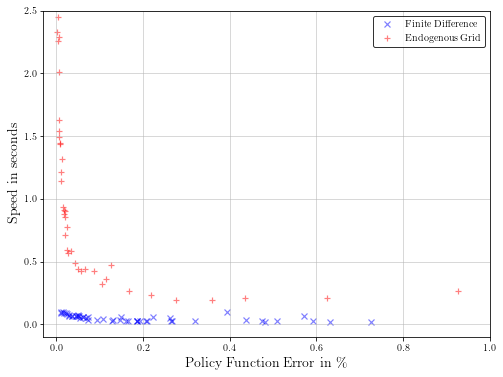

In [42]:
# Generate
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)

# Settings
ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.7')
ax.set_xlim([-0.03,1])
ax.set_ylim([-0.1,2.5])
ax.set_ylabel(r'Speed in seconds', size=14)
ax.set_xlabel(r'Policy Function Error in \%', size=14)

# Plot
ax.scatter(error_fd_av,time_fd_av,marker='x', alpha = 0.5, edgecolor = 'k', linewidth=1.2, color = 'blue', label = 'Finite Difference')
ax.scatter(error_egm,time_egm, marker='+', alpha = 0.5, edgecolor = 'k', linewidth=1.2, color = 'red', label = 'Endogenous Grid')

ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white')
plt.savefig('tradeoff.pdf')